In [1]:
import sys, os
sys.path.append(os.path.realpath(".."))

import util_funcs
from importlib import reload
reload(util_funcs)
from copy import deepcopy as cp

import data_reader as read
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import pywt
import tsfresh.feature_extraction.feature_calculators as feats
import constants
import clinical_text_analysis as cta
reload(cta)
import tsfresh
import ensembleReader as er
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, r2_score, classification_report
from os import path

reload(read)
import wf_analysis.datasets as wfdata
import wf_analysis.filters as filt
reload(filt)
from addict import Dict
import time
import pickle as pkl
import tsfresh.feature_extraction.feature_calculators as tsf
import pyedflib as edf
import keras_models.dataGen as dg 

Using Theano backend.


In [2]:
%%bash
ls /home/ms994/dbmi_eeg_clustering/assets

3d_positions.csv
None_01_tcp_ar_file_lengths.csv
channel_names.csv
combined_01_tcp_ar_file_lengths.csv
data_labels.csv
dev_test_01_tcp_ar_file_lengths.csv
seizures.csv
train_01_tcp_ar_file_lengths.csv


In [3]:
labels = pd.read_csv("/home/ms994/dbmi_eeg_clustering/assets/data_labels.csv")

In [4]:
labels

,class_code,class_no,description
0,NaN,0,No Event
1,SPSW,1,Spike/Sharp and Wave
2,GPED,2,Generalized Periodic Epileptiform Discharges
3,PLED,3,Periodic Lateralized Epileptiform Discharges
4,EYBL,4,Eye blink
5,ARTF,5,Artifacts (All)
6,BCKG,6,Background
7,SEIZ,7,Seizure
8,FNSZ,8,Focal Non-Specific Seizure
9,GNSZ,9,Generalized Non-Specific Seizure


In [23]:
seizure_data = pd.read_csv("/home/ms994/dbmi_eeg_clustering/assets/train_01_tcp_ar_file_lengths.csv", header=None)

In [24]:
seizure_data

,0,1
0,/home/ms994/v1.5.0/edf/train/01_tcp_ar/131/000...,1305
1,/home/ms994/v1.5.0/edf/train/01_tcp_ar/131/000...,601
2,/home/ms994/v1.5.0/edf/train/01_tcp_ar/131/000...,300
3,/home/ms994/v1.5.0/edf/train/01_tcp_ar/131/000...,601
4,/home/ms994/v1.5.0/edf/train/01_tcp_ar/131/000...,300
5,/home/ms994/v1.5.0/edf/train/01_tcp_ar/131/000...,300
6,/home/ms994/v1.5.0/edf/train/01_tcp_ar/131/000...,300
7,/home/ms994/v1.5.0/edf/train/01_tcp_ar/131/000...,601
8,/home/ms994/v1.5.0/edf/train/01_tcp_ar/131/000...,300
9,/home/ms994/v1.5.0/edf/train/01_tcp_ar/131/000...,601


In [15]:
seizure_count = pd.read_csv("/home/ms994/dbmi_eeg_clustering/assets/seizures.csv")

In [20]:
seizure_count = seizure_count.loc[ ~pd.isnull(seizure_count["seizure_start"])]

In [23]:
(seizure_count.seizure_stop-seizure_count.seizure_start).sum()

229176.0688

In [2]:
train_edss = pkl.load(open("/n/scratch2/ms994/train_multiple_labels_sessions_montage_seizure_data_4.pkl", "rb"))

In [4]:
len(train_edss)

239325

In [5]:
train_seizure_labels = [datum[1][0] for datum in train_edss]
train_session_labels = [datum[1][1] for datum in train_edss]
train_subtype_labels = [datum[1][2] for datum in train_edss]
train_montage_labels = [datum[1][3] for datum in train_edss]

In [9]:
montages = pd.concat(train_montage_labels, axis=1)

In [11]:
montages = montages.T

In [12]:
montages = montages.reset_index()

In [16]:
montages = montages.drop(["index"], axis=1)

In [18]:
seizure_montages = montages.loc[train_seizure_labels]

<BarContainer object of 22 artists>

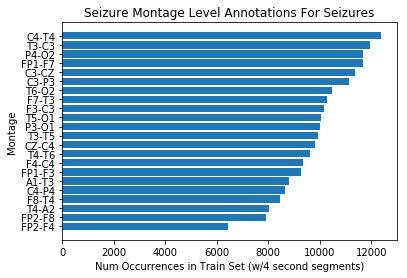

In [28]:
sum_all = seizure_montages.sum()
sum_all = sum_all.sort_values()
plt.title("Seizure Montage Level Annotations For Seizures")
plt.xlabel("Num Occurrences in Train Set (w/4 second segments)")
plt.ylabel("Montage")
plt.barh(y=sum_all.index, width=sum_all, )

(array([2462., 2121., 1945., 2382., 1440., 4145.,  678., 1324.,   55.,
        3701.]),
 array([ 0. ,  2.2,  4.4,  6.6,  8.8, 11. , 13.2, 15.4, 17.6, 19.8, 22. ]),
 <a list of 10 Patch objects>)

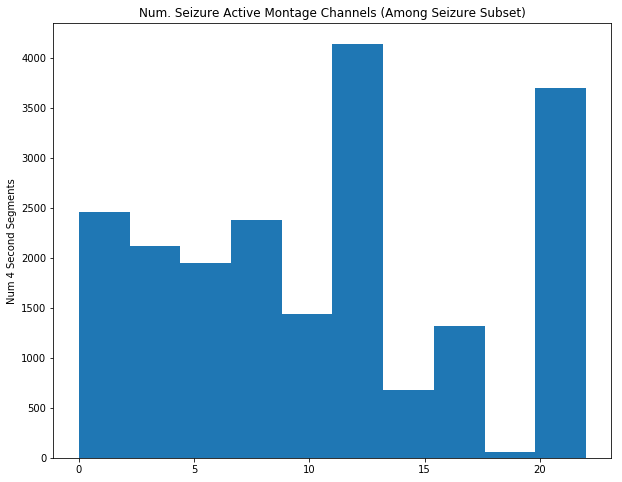

In [36]:
plt.figure(figsize=(10,8))
plt.title("Num. Seizure Active Montage Channels (Among Seizure Subset)")
plt.ylabel("Num 4 Second Segments")
plt.hist(seizure_montages.sum(axis=1))

In [6]:
train_edss[0][0].std()

14.941495870360056

In [7]:
stdTrainEds = [datum[0].std() for datum in train_edss]

239325

In [16]:
(pd.Series(stdTrainEds)>100).sum()/len(stdTrainEds)

0.08042202026532957

In [17]:
df = pd.DataFrame([stdTrainEds, train_seizure_labels], index=["std", "seiz"] )

In [27]:
df.T.loc[df.T["std"] <= 100].seiz.mean()

0.08283881169403576

In [2]:
import pyprep
import mne

In [4]:
edf_files = read.get_all_token_file_names("train", "01_tcp_ar")

In [1]:
croppedData = data.crop(0,10)

NameError: name 'data' is not defined

In [3]:
import numpy as np
np.arange(60, data.info["sfreq"]/2, 60)

NameError: name 'data' is not defined

In [16]:
fails = 0
success = 0

In [6]:
len(edf_files)

NameError: name 'edf_files' is not defined

In [4]:
for i in range(400):
    data = mne.io.read_raw_edf(edf_files[580], preload=True)
    data = data.pick_channels(util_funcs.get_common_channel_names())
    data.rename_channels(constants.MNE_CHANNEL_EDF_MAPPING)
    data.set_montage("standard_1020")
    data.resample(512)
    montage_kind = "standard_1020"
    prep_params = {'ref_chs': data.ch_names,
                   'reref_chs': data.ch_names,
                   'line_freqs': np.arange(60, data.info["sfreq"]/2, 60)}
    montage = mne.channels.make_standard_montage(montage_kind)
    dataSubset = data.crop(i*10,i*10+30)
    prep = pyprep.PrepPipeline(dataSubset, prep_params, montage, ransac=False)
    try:
        prep.fit()
        success+=1
    except Exception:
        print("failure")
        fails += 1
        

NameError: name 'mne' is not defined

In [18]:
success, fails

(13, 4)

In [5]:
data = prep.raw.plot()

NameError: name 'prep' is not defined

(21, 30001)

In [30]:
print("Bad channels: {}".format(prep.interpolated_channels))
print("Bad channels original: {}".format(prep.noisy_channels_original['bad_all']))
print("Bad channels after interpolation: {}".format(prep.still_noisy_channels))

Bad channels: ['A2', 'Pz']
Bad channels original: []
Bad channels after interpolation: ['A2']


In [2]:
mne.Epochs(data)

NameError: name 'mne' is not defined

In [5]:
ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')
print(ten_twenty_montage)

<DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 94 channels>


In [8]:
from importlib import reload

In [20]:
reload(constants)

<module 'constants' from '/home/ms994/dbmi_eeg_clustering/constants.py'>

In [34]:
import preprocessing_v2 as v2
reload(v2)

<module 'preprocessing_v2' from '/home/ms994/dbmi_eeg_clustering/preprocessing_v2.py'>

In [ ]:
extra_channels =

In [46]:
data.ch_names

AttributeError: 'NoneType' object has no attribute 'ch_names'

ValueError: DigMontage is a only a subset of info. There are 9 channel positions not present it the DigMontage. The required channels are: {'EEG T2-REF', 'EEG EKG1-REF', 'SUPPR', 'EEG LOC-REF', 'PHOTIC-REF', 'EEG T1-REF', 'BURSTS', 'IBI', 'EEG ROC-REF'}.
You can use `raise_if_subset=False` in `set_montage` to avoid this ValueError and get a DeprecationWarning instead.

In [37]:
type(data)

mne.io.edf.edf.RawEDF

In [ ]:
ten_twenty_montage

In [ ]:
data

In [37]:
from importlib import reload
reload(pyprep)

ModuleNotFoundError: spec not found for the module 'pyprep'

In [2]:
from pyedflib import EdfReader
from pyprep.prep_pipeline import PrepPipeline

In [29]:
reader = EdfReader(edf_files[580])
print(reader.getSampleFrequencies())
# reader.close()


[1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000    1
    1    1]


In [34]:
reader.readSignal(0).shape

(1380000,)